# Polymers

## Fancy fuckings innledning goes here

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

TODO: Skriv akademisk

We begin by implementing the polymer and corresponding functions needed for rotations and visualization. There are several ways to implement the polymer, one way is to use an N x N matrix containing the index of each individual monomer. Another possibility, which we have opted for, is to store the polymer as a list of length N where each element of the list is a list of length two, containing the X and Y coordinates of the monomer with the respective index. Note that our is then zero-indexed.

The advantages of going for this approach is that operations done on the entirety of the data structure achieves an asymptotic runtime of $O(n)$, an order of magnitude better than $O(n^2)$ for the NxN matrix approach, while still being compatible with numpy, letting us take advantage of the fast implementations and parallell computing possibilities within numpy.

A function that creates a polymer spanning a horizontal line is given below the library imports.

In [134]:
# Import and define necessary libraries and constants
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist

#Boltzmanns konstant
k_B = 1.38e-23 #J/K

In [135]:
# 1b)
def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.
TODO: Skriv akademisk

A rotation about the first or last polymer will not alter the energy at all. Changes in energy arise when monomers that were not previously interacting gets placed such that an interaction arises, or vice versa. As a rotation around a monomer at the endpoint rotates the entire polymer, no relative distances are altered. Therefore, when simulating random rotations, we can disregard such rotations without consequences for the final result. 

**Skal vi skrive tekst om 1d)?**

In [136]:
def visualizePolymer(polymer, title=""):
    # Calculate the minimum and maximum coordinates of the polymer
    minX = int(np.min(polymer[:, 0]))
    maxX = int(np.max(polymer[:, 0]))
    minY = int(np.min(polymer[:, 1]))
    maxY = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    gridWidth = maxX - minX + 1
    gridHeight = maxY - minY + 1
    gridSize = int(np.max([gridHeight, gridWidth]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((gridSize, gridSize))

    # Plot the polymer on the grid
    for i, (x, y) in enumerate(polymer):
        grid[int(y - minY), int(x - minX)] = i + 1

    # Visualize the grid
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    if title != "":
        plt.title(title, fontsize=15)
    plt.show()
    

def visualizeMultiplePolymers(polymer, ax):
    # Calculate the minimum and maximum coordinates of the polymer
    minX = int(np.min(polymer[:, 0]))
    maxX = int(np.max(polymer[:, 0]))
    minY = int(np.min(polymer[:, 1]))
    maxY = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    gridWidth = maxX - minX + 1
    gridHeight = maxY - minY + 1
    gridSize = int(np.max([gridHeight, gridWidth]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((gridSize, gridSize))

    for i, (x, y) in enumerate(polymer):
        grid[int(y - minY), int(x - minX)] = i + 1
    
    ax.pcolormesh(grid, edgecolors='black', linewidth=0.5, cmap=cmap)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')

It is necessary to ensure that a rotation returns a valid polymer. The function isIntact implemented below returns True if the polymer fullfills the following criteria:

1. The polymer has $N$ monomers that all have unique coordinates.
2. Monomer $i$ s a distance of $1$ to monomer $i-1$, where $i \in \left[1,N\right)$

The function returns false elsewise.

**Burde den neste teksten stå under implementasjonen?**

These two checks are sufficient to check the criteria given in the task description when the polymer is defined using our data structure. The length of a polymer will always be N, as long as the algorithms operating on the polymer do not alter the length. Nevertheless, the first criteria will still ensure that this is the case, as the parameter $N$ of isIntact is the length the polymer should be. If the polymer consists of less than $N$ monomers, it cannot have more than $N$ unique monomers. 

The unique representation of a monomer is given by the list index of the coordinate representing the monomer.

For the final check, we utilize symmetry in distance, namely that the distance between $a$ and $b$ is the distance between b and a. Therefore, when we check if each monomer except the leftmost has a distance of 1 to its left neighbor, we also check that each monomer except the rightmost has a distance of 1 to its right neighbor.

In [137]:
# 1e)

def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    
    # Remove potential monomers in identical positions, and check if this shortens the polymer. If so, return false.
    uniLength = len(np.unique(polymer, axis=0))

    if uniLength != N:
        return False

    # Check if the distance between each adjacent monomer is 1, i.e. that the polymer chain is continous. If not, return false.
    # TODO: Vurder å prøve å fjerne for
    for i in range(N-1): 
        xDist = np.abs(polymer[i+1][0]-polymer[i][0])
        yDist = np.abs(polymer[i+1][1]-polymer[i][1])
        distance = xDist + yDist
        if distance != 1:
            return False
    return True

One way to rotate the polymer is to use the direction where we can find the next monomer from the previous one, and change this clockwisely or counterclockwisely dependent of which direction we want to rotate. The function createDirectionList below is useful when rotating in this way.

In [138]:
#TODO: Skriv om vha. rotasjonsmatrise. Bruk (blant annet) dette som svar i 1h)
def createDirectionList(polymer):
    """Input the part of a polymer that you want to rotate, and find what direction it rotates"""
    
    # Create a zero-array that is the length of the polymer part that you want to rotate (minus 1)
    dir = np.zeros(len(polymer)-1)
    
    for i in range(len(polymer)-1):
        d = polymer[i+1] - polymer[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


The algorithm for the rotation itself can be found below. The asymptotic runtime of the algorithm is $O(n)$, but the implementation leads to a relatively large constant factor, leading to a somewhat inefficient algorithm even though it scales well.

In [139]:
def rotatePolymer(polymer, rotationOrigin, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    
    rotatingBase = -1 
    polymer = np.copy(polymer)
    N = len(polymer)

    # Find index of monomer to rotate around
    for i in range(N):
        if np.array_equal(polymer[i], rotationOrigin):
            rotatingBase = i
            break
    
    # Find which side to rotate about. 
    rotateLeftPart = rotatingBase <= N//2

    directionList = createDirectionList(polymer)

    # Change the rotational direction in direction list according to rotating direction and which part to rotate.
    if rotateLeftPart:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4

    # Place the end of the polymer iteratively
    if rotateLeftPart:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, N):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

A more efficient way to implement this algorithm is to utilize rotational matrices. To rotate a point $\mathbf{p}$ with an angle $\theta$ around the origin, one can apply the linear transformation given by the matrix
$A = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}$
to $\mathbf{p}$. As we want only want to rotate 90 degrees clockwisely and counterclockwisely, we only need to consider the matrices $A_+ = \begin{bmatrix}
0 & -1 \\
1 & 0
\end{bmatrix}$
and  $A_- = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}$
respectively. Then, we translate the entire coordinate system to have the origin where the monomer we rotate about is located, perform the rotation on the shortest part, and translate back. 


In [140]:
# Bruk i 1 h)

def rotatePolymer(polymer, rotationOrigin, clockwise = True):
    """Inputs a polymer and rotates the short end in the direction specified around rotation origin."""

    # Create a clockwise- or counterclockwise-rotation matrix, depending on the input.
    rotationMatrix =  np.array([[0, 1], [-1, 0]]) if clockwise else np.array([[0, -1], [1, 0]])

    # Find the index of the monomer you want the polymer to rotate about
    rotationCenterIdx = np.where((polymer == rotationOrigin).all(axis=1))[0][0]

    # Move the rotation center to the origin before rotating
    translatedPolymer = polymer - rotationOrigin

    # Make a copy of translatedPolymer to ensure no loss of data due to pass-by-reference used in np.arrays
    rotatedPolymer = np.copy(translatedPolymer)

    # Check on what side of the polymer the monomer you rotate about is, so the shortest end always is the one that is rotated.
    if rotationCenterIdx <= len(polymer)//2:
        rotatedPolymer[:rotationCenterIdx] = rotatedPolymer[:rotationCenterIdx] @ rotationMatrix
    else:
        rotatedPolymer[rotationCenterIdx + 1:] = rotatedPolymer[rotationCenterIdx + 1:] @ rotationMatrix
    return rotatedPolymer + rotationOrigin

To test the rotate function, we define a function which will run it a given number of times and returns the number of valid rotations, that being those rotations that return a polymer that fulfills the criteria given for isIntact.

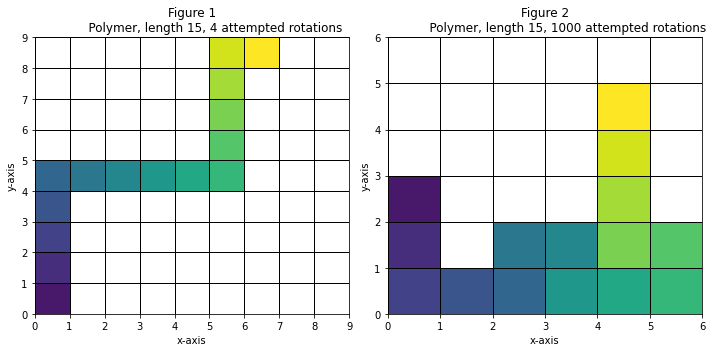

In [141]:
# 1g)

def testRotate(N, N_s):
    """Inputs the length of a polymer and number of attempted rotations, and outputs the last position and number of successful rotations"""
    
    # Create a polymer with given length, aswell as an empty array and a counter for number of successfull rotations
    polymer = createPolymer(N)
    twistedPolymer = np.array([])
    successRotations = 0

    # Twist the given polymer N_s times
    for i in range(N_s):

        # Find a random monomer to rotate about, and a random direction, either clockwise or counterclockwise
        rotateMonomer = np.random.randint(1, N+1)
        rotateMonomer = polymer[rotateMonomer - 1]
        clockwise = np.random.randint(0,2) == 1

        # Create a new twisted polymer, depending on the random monomer and direction given above
        twistedPolymer = rotatePolymer(polymer, rotateMonomer, clockwise)

        # Check if the twisted polymer is intact, and if so, this is the new polymer, add 1 to the counter, and use this polymer for the remaining iterations
        # If not, the next iteration will use the last valid polymer
        if isIntact(twistedPolymer, N) == True:
            successRotations += 1 
            polymer = np.copy(twistedPolymer)
    
    return polymer, successRotations

# Create two test-rotations for a polymer that is N = 15 monomers long, one with N_s = 4 and the other with N_s = 1000
polymer4, successes4 = testRotate(15, 4)
polymer1000, successes1000 = testRotate(15, 1000)

polymerArray = np.array([polymer4, polymer1000])

# Visualize the end position of the two tests
fig, axs = plt.subplots(1, len(polymerArray), figsize=(10, 5))

# Plot each run on a separate subplot
for i, polymer in enumerate(polymerArray):
    visualizeMultiplePolymers(polymer, axs[i])

axs[0].set_title(f"""Figure 1
            Length 15, 4 attempted, {successes4} successful rotations""")
axs[1].set_title(f"""Figure 2
            Length 15, 1000 attempted, {successes1000} successful rotations""")
plt.tight_layout()
plt.show()


As we see from the figure above, the polymer that goes through the most rotations is the one that ends up being the most curled up.

We have already discussed one optimization in the rotation algorithm, where we make use of numpy to do rotations in parallell. Generally, numpy is also fast because it is implemented in C, a compiled language. To see this, we run the test function above with both implementations of the rotation.

In [142]:
# TODO: Sett inn 1h her

In [143]:
#1i)

def successRot(N_s):
    """Inputs a number of attempted rotations, and returns number of successful rotations"""

    # Create an array for N ranging from 10 to 600, and a zero-array with the length of this array
    N = np.arange(10, 600, 20)
    successRate = np.zeros(len(N))

    # Create a for-loop for increasing N-values, where in each iteration the number of successful rotations are returned as a percentage,
    # and the percentage is appended to an array, and return this array
    for i in range(len(N)):
        successes = testRotate(N[i], N_s)[1]
        percentage = successes * 100/N_s
        successRate[i] = percentage

    return N, successRate

In [144]:
N, successRate500 = successRot(500)
N, successRate1500 = successRot(1500)
N, successRate4000 = successRot(4000)

/var/folders/y3/1w5k7p493sl56cbk6014g7mw0000gn/T/ipykernel_57348/3693852816.py:5: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


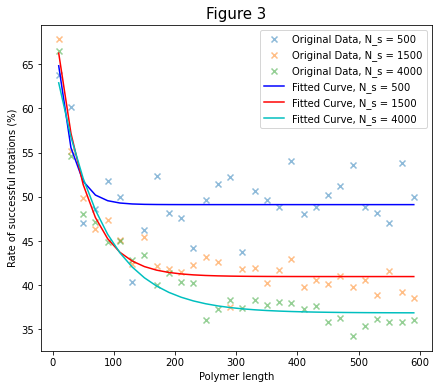

In [145]:
# Perform curve fitting
initialGuess = (1, 0.01, 1)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt1, pcov1 = curve_fit(func, N, successRate500, p0=initialGuess)
popt2, pcov2 = curve_fit(func, N, successRate1500, p0=initialGuess)
popt3, pcov3 = curve_fit(func, N, successRate4000, p0=initialGuess)

# Extract optimized parameters
aFit, bFit, cFit = popt1
d, e, f = popt2
g, h, i = popt3

# Generate y values using the fitted parameters
yPred500 = func(N, aFit, bFit, cFit)
yPred1500 = func(N, d, e, f)
yPred4000 = func(N, *popt3)

# Plot the original data and the fitted curve
plt.figure(figsize=(7,6))
plt.scatter(N, successRate500, marker="x", alpha=0.5, label='Original Data, N_s = 500')
plt.scatter(N, successRate1500, marker="x", alpha=0.5, label='Original Data, N_s = 1500')
plt.scatter(N, successRate4000, marker="x", alpha=0.5, label='Original Data, N_s = 4000')
plt.plot(N, yPred500, 'b-', label='Fitted Curve, N_s = 500')
plt.plot(N, yPred1500, 'r-', label='Fitted Curve, N_s = 1500')
plt.plot(N, yPred4000, 'c-', label='Fitted Curve, N_s = 4000')
plt.xlabel('Polymer length')
plt.ylabel('Rate of successful rotations (%)')
plt.title('Figure 3', fontsize=15)
plt.legend()
plt.show()

In [146]:
# 1j)

def calculateEnergy(polymer, V):
    """Input a polymer and an interaction energy-matrix, and return the total energy of the polymer"""

    # Create a bool, b, that returns true if two monomers are next to eachother
    b = cdist(polymer, polymer, 'cityblock') == 1

    # Create a new matrix by multiplying V and b, that contains the interaction energy values from V where two monomers are next to eachother, i.e. where b is true
    energyMatrix = np.multiply(V,b)

    # Summate the individual energy-interactions, and return half of the sum
    return np.sum(energyMatrix)/2

# Create an interaction energy-matrix that is -1 everywhere but the three central diagonals, which contain zeros
V = np.zeros([len(polymer1000),len(polymer1000)])
V[np.tril_indices_from(V,-2)] = -1
V[np.triu_indices_from(V,2)] = -1

print(f'Energy for polymer of length 15 with 4 tried rotations: {calculateEnergy(polymer4,V)}')
print(f'Energy for polymer of length 15 with 1000 tried rotations: {calculateEnergy(polymer1000,V)}') 

Energy for polymer of length 15 with 4 tried rotations: 0.0
Energy for polymer of length 15 with 1000 tried rotations: -3.0


In [147]:
#2a)

def metropolis(polymer, N_s, V, T):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns a twisted polymer and an array containing the energy of each twisted polymer"""

    beta = 1/(k_B*T)
    
    # Initialize required values for N, i and the energy, and an array for E
    N = len(polymer)
    energyArray = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    energyArray[0] = E
    i = 0

    while i < N_s:
        # Find the index of a random monomer, excluding the end-monomers, and use this as the coordinates to rotate about 
        xRand = np.random.randint(1, N-1)
        rotationOrigin = polymer[xRand]

        # Find a random direction, and use this and the rotation origin to create a twisted polymer
        clockwise = np.random.randint(0,2) == 1
        twistedPolymer = rotatePolymer(polymer, rotationOrigin, clockwise)

        # Check if the twisted polymer is intact, and if so calculate it's energy
        if isIntact(twistedPolymer, N):
            newE = calculateEnergy(twistedPolymer, V)

            # If the energy of this new polymer is lower than for the previous polymer, 
            # or the probability of a random rotation is higher than a random probability, 
            # save this polymer as the new polymer, with correlating energy. Save this in the energy array, and increase the increment
            if newE < E or np.exp(-beta*(newE - E)) > np.random.uniform():
                polymer = np.copy(twistedPolymer)
                E = newE
            energyArray[i] = E
            i += 1
            
    return polymer, energyArray

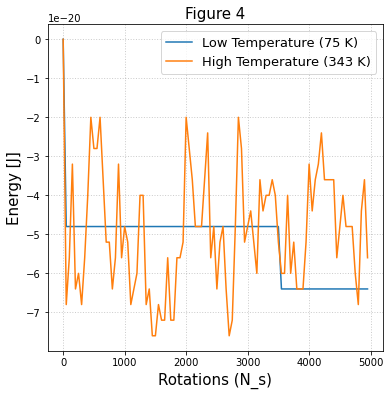

In [148]:
# 2b

# Define N and correlating polymer for the remainder of the report
N = 30
polymer = createPolymer(N)

N_s = 5000
nonzeroE = -4e-21

V = np.zeros([N, N])
V[np.tril_indices_from(V,-2)] = nonzeroE
V[np.triu_indices_from(V,2)] = nonzeroE

lowT = 75
highT = 343

lowTPolymer, lowTEnergyArray = metropolis(polymer, N_s, V, lowT)
highTPolymer, highTEnergyArray = metropolis(polymer, N_s, V, highT)

t = np.arange(0,len(lowTEnergyArray))

plt.figure(figsize=(6,6))
plt.title("Figure 4", fontsize=15)
plt.xlabel("Rotations (N_s)", fontsize=15)
plt.ylabel("Energy [J]", fontsize=15)
plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
plt.plot(t[::50],lowTEnergyArray[::50], label=f"Low Temperature ({lowT} K)")
plt.plot(t[::50],highTEnergyArray[::50], label=f"High Temperature ({highT} K)")
plt.legend(fontsize=13)
plt.show()

### 2b)
The simulation of the polymer at lower temperatures results in the lowest energy observed throughout the simulation. This is attributable to the heightened probability of energy-efficient rotations for a polymer in a lower temperature environment. Despite the system's inclination to minimize energy, thermal fluctuations can still induce energy-inefficient rotations. As temperature increases, the likelihood of such fluctuations rises. 

As a result, the polymer at lower temperatures quickly settles into a local energy minimum after a few rotations. In this state, there are fewer opportunities for energy-efficient rotations. Combined with the low likelihood of energy-inefficient rotations in a low-temperature environment, this results in fewer overall rotations for the polymer.

*Insert energy minima theory?* 

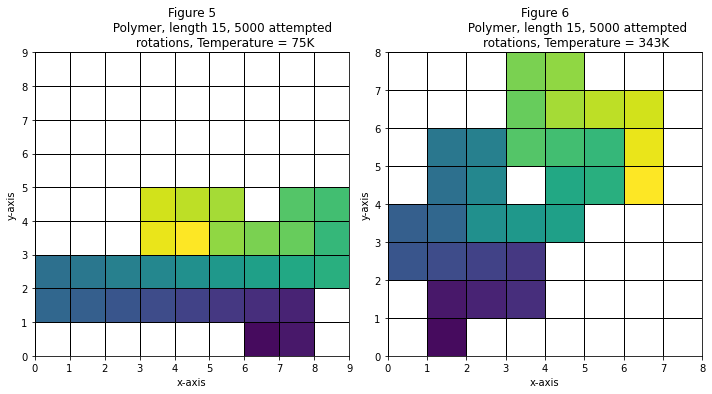

In [149]:
# 2c

polymerData = np.array([lowTPolymer, highTPolymer])
fig, axs = plt.subplots(1, len(polymerData), figsize=(10, 5))

for i, polymer in enumerate(polymerData):
    visualizeMultiplePolymers(polymer, axs[i])

plt.tight_layout()
axs[0].set_title("""Figure 5
                 Polymer, length 15, 5000 attempted 
                 rotations, Temperature = 75K""")
axs[1].set_title("""Figure 6
                 Polymer, length 15, 5000 attempted
                rotations, Temperature = 343K""")
plt.show()

### 2c)
The figures above illustrate that the polymer at lower temperatures exhibits more folding compared to the polymer at higher temperatures. This observation aligns with the tendency for polymers at higher temperatures to undergo energy-inefficient rotations. A polymer undergoing solely energy-efficient rotations will gradually adopt a ball-like structure, consistent with the curled appearance observed in these figure to the left.

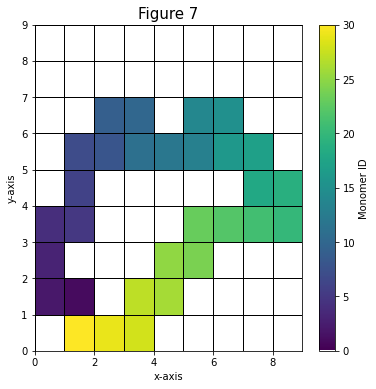

In [150]:
# 2d
#TODO: Denne matrisen stemmer ikke, diagonal != 0. Den er også lite interessant.

unevenV = np.zeros([N, N])
unevenV[0][-1] = -100e-20
unevenV[-1][0] = -100e-20

for i in range(1, len(polymer//2 + 1)):
    unevenV[i:-i, i:-i] *=10

unevenPolymer, unevenE = metropolis(polymer, 10000, unevenV, 150)

visualizePolymer(unevenPolymer, 'Figure 7')

### 2d)
For our $V$ matrix, we have chosen to set all elements to zero except for the lower left and upper right corners, which we have set to $-100 \times 10^{-12} , \text{J}$. The purpose of this energy distribution is to facilitate the binding of the polymer ends. This interaction between the two ends represents the only energy-efficient folding of the polymer in this configuration, leading to their eventual binding.

In [151]:
# 2e)

Temperature = np.arange(10,1000,30)

def energyPerT(N_s):
    """Inputs number of attempted rotations, and returns an array containing the energy per temperature"""
    
    energyArray = np.zeros([33, N_s - 1000])

    for i in range(len(Temperature)):
        energyArray[i] = metropolis(polymer, N_s, V, Temperature[i])[1][1000:]

    return energyArray

In [152]:
runNs1500 = energyPerT(1500)
runNs3000 = energyPerT(3000)
runNs6000 = energyPerT(6000)

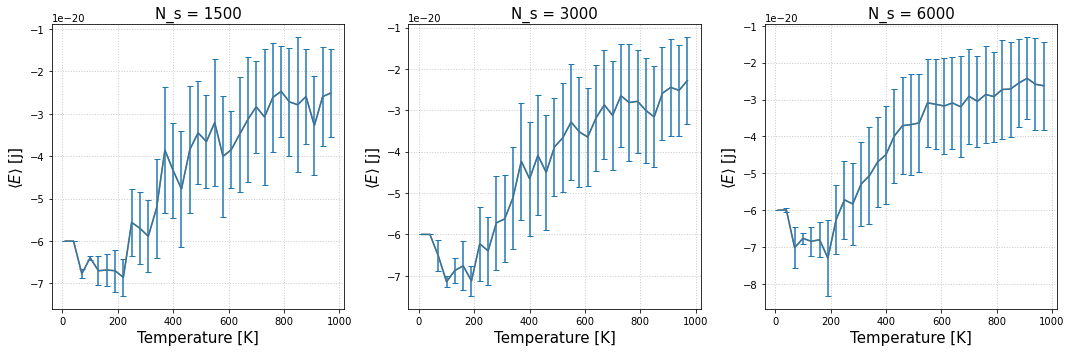

In [153]:
meanRunNs1500 = np.mean(runNs1500, axis=1)
stdRunNs1500 = np.std(runNs1500, ddof=1, axis=1)

meanRunNs3000 = np.mean(runNs3000, axis=1)
stdRunNs3000 = np.std(runNs3000, ddof=1, axis=1)

meanRunNs6000 = np.mean(runNs6000, axis=1)
stdRunNs6000 = np.std(runNs6000, ddof=1, axis=1)

# Create figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot data on the first subplot
axs[0].errorbar(Temperature, meanRunNs1500, yerr=stdRunNs1500, fmt='-', capsize=3)
axs[0].plot(Temperature, meanRunNs1500)
axs[0].grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
axs[0].set_xlabel("Temperature [K]", fontsize=15)
axs[0].set_ylabel("$\\langle E \\rangle$ [j]", fontsize=15)
axs[0].set_title('N_s = 1500', fontsize=15)

# Plot data on the second subplot
axs[1].errorbar(Temperature, meanRunNs3000, yerr=stdRunNs3000, fmt='-', capsize=3)
axs[1].plot(Temperature, meanRunNs3000)
axs[1].grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
axs[1].set_xlabel("Temperature [K]", fontsize=15)
axs[1].set_ylabel("$\\langle E \\rangle$ [j]", fontsize=15)
axs[1].set_title("N_s = 3000", fontsize=15)

# Plot data on the third subplot
axs[2].errorbar(Temperature, meanRunNs6000, yerr=stdRunNs6000, fmt='-', capsize=3)
axs[2].plot(Temperature, meanRunNs6000)
axs[2].grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
axs[2].set_xlabel("Temperature [K]", fontsize=15)
axs[2].set_ylabel("$\\langle E \\rangle$ [j]", fontsize=15)
axs[2].set_title('N_s = 6000', fontsize=15)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### 2e)
*Notat:*
- ser at grafen blir glattere ved et høyere antall rotasjoner - > gjennomsnittlig energi stiger mer stabilt ved høyt rotasjonstall
- ser at standardavviket blir høyere ved høyere temperatur - > gir mening, polymeren gjør flere ugunstige rotasjoner ved høyere temperatur som vil resultere i store energihopp, som resulterer i stort standardavvik fra gjennomsnittet.

Observing the plot, it becomes evident that the magnitude of the mean energy decreases as temperatures rise. This observation aligns with the findings presented in \ref{2b}. Additionally, an increase in temperature corresponds to an escalation in the magnitude of the standard deviation. This correspondence is consistent with the observations in \ref{2b}, where the polymer's energy exhibits considerable sporadic fluctuations at higher temperatures. Consequently, the standard deviation appears significantly larger in comparison to the mean energy, as depicted in the plot.

Both the mean energy, and the standard deviation is clearly temperature dependant? 

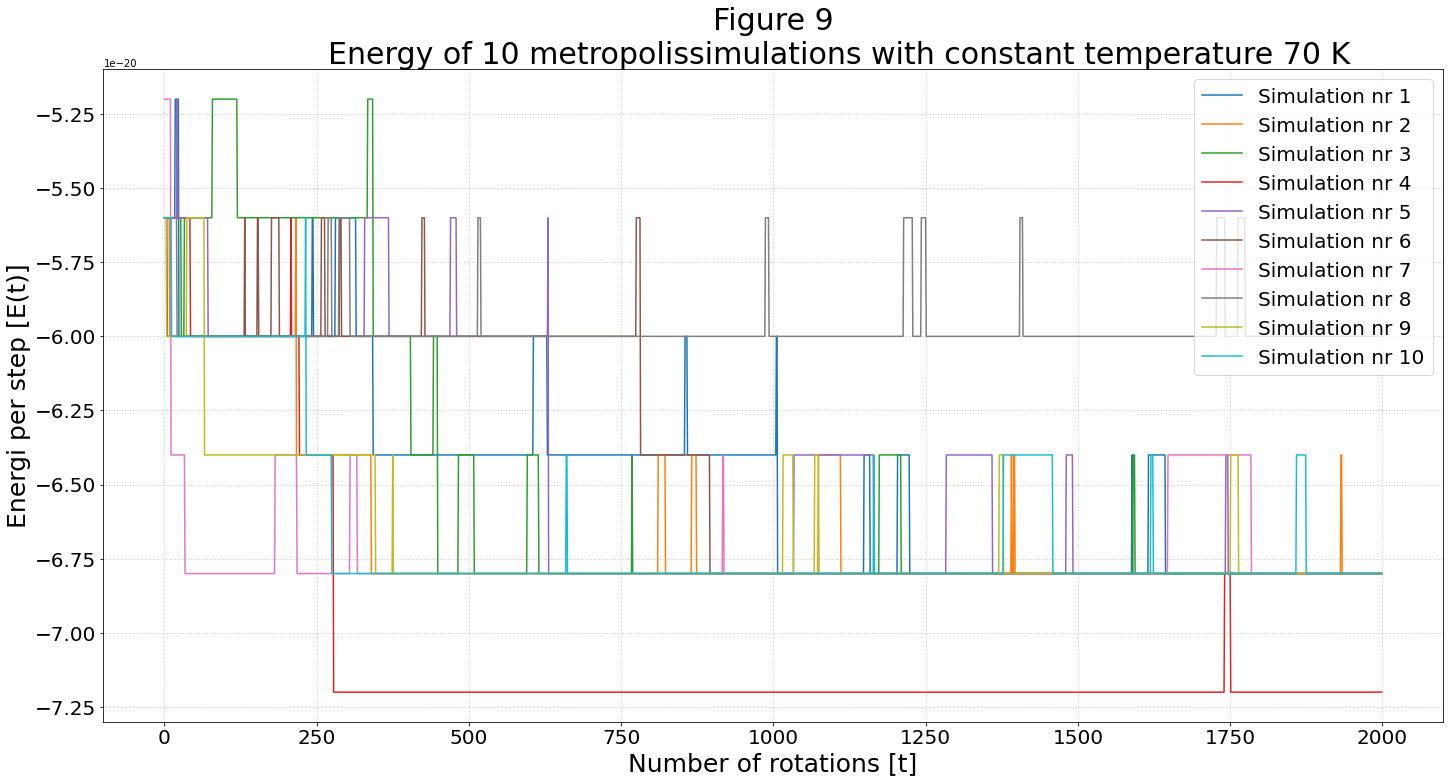

In [154]:
# 2f

T = 70 #K
N_s = 2000

def energyConstantT(T, N_s, V):
    """Inputs a temperature, number of attempted rotations and an interaction-energy matrix, 
    and plots ten simulations for the energy as a function of number of rotations"""

    iArr = np.arange(0, N_s)

    plt.figure(figsize=(24, 12))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Number of rotations [t]", fontsize=25)
    plt.ylabel("Energi per step [E(t)]", fontsize=25)
    plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
    plt.title(f"""Figure 9
              Energy of 10 metropolissimulations with constant temperature {T} K""", fontsize=30)
    
    for i in range(1, 11):
        metro = metropolis(polymer, N_s, V, T)
        plt.plot(iArr, metro[1], label = f"Simulation nr {i}")
    
    plt.legend(fontsize=20)

energyConstantT(T, N_s, V)

### 2f)
The plot illustrates that polymers at lower temperatures swiftly converge to a rotation that positions them within a local energy minimum. Notably, the majority of polymers reach their initial local minima within the first 0-100 rotations. Subsequently, once situated within an energy minimum, the polymer's available energy-efficient rotation possibilities become limited. Consequently, the polymer refrains from executing rotations until an energy-efficient option is identified. However, occasional deviations from this behavior occur, characterized by energy-inefficient rotations, primarily attributed to thermal fluctuations as discussed in \ref{2b}.

### 2g)
Here we ...

In [155]:
# 2g

def getEuclideanDistance(polymer):
    return np.max(cdist(polymer, polymer, 'euclid'))

def metropolisWithD(polymer, N_s, V, T):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns a twisted polymer, an array containing the energy of each twisted polymer, and an array containing the biggest distance between two monomers for each twisted polymer"""

    beta = 1/(k_B*T)

    N = len(polymer)
    energyArray = np.zeros(N_s)
    dArr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    energyArray[0] = E
    i = 0
    
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        rotationOrigin = polymer[xRand]

        clockwise = bool(np.random.randint(0,2))
        twistedPolymer = rotatePolymer(polymer,rotationOrigin, clockwise)

        if isIntact(twistedPolymer, N):
            newE = calculateEnergy(twistedPolymer, V)
            
            if newE < E or np.random.uniform() < np.exp(-beta*(newE - E)):
                polymer = np.copy(twistedPolymer)
                E = newE
            energyArray[i] = E
            dArr[i] = getEuclideanDistance(polymer)
            i += 1

    return polymer, energyArray, dArr

To create the random symmetrical matrix, we...

In [156]:
# Define the interval
lowerBound = -6e-21
upperBound = -2e-21

# Generate a random upper triangular matrix within the specified interval
randomMatrix = (upperBound - lowerBound) * np.random.rand(30, 30) + lowerBound
upperTriangular = np.triu(randomMatrix, 1)

# Construct the symmetrical matrix by copying the upper triangular part to the lower triangular part
symmetricalMatrix = upperTriangular + upperTriangular.T

# Set the diagonal elements and the diagonals on each side of the main diagonal to zero
for i in range(30):
    symmetricalMatrix[i, i] = 0
    if i > 0:
        symmetricalMatrix[i, i-1] = 0
        symmetricalMatrix[i-1, i] = 0


Plotting the mean diameter as a funtion of the temperature changes.

In [157]:
dArray = np.zeros([33, 9000])
eArray = np.zeros([33, 9000])

for i in range(len(Temperature)):
    dArray[i] = metropolisWithD(polymer, 10000, symmetricalMatrix, Temperature[i])[2][1000:]
    eArray[i] = metropolisWithD(polymer, 10000, symmetricalMatrix, Temperature[i])[1][1000:]


meansDArray = np.array([np.mean(subarray) for subarray in dArray])
meansEArray = np.array([np.mean(subarray) for subarray in eArray])

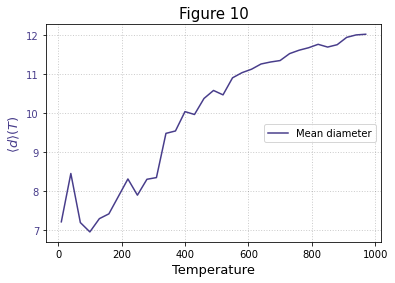

In [158]:
plt.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
plt.ylabel('$\\langle d \\rangle (T)$', fontsize=13, color='darkslateblue')
plt.xlabel('Temperature', fontsize=13)
plt.tick_params(axis='y', labelcolor='darkslateblue')
plt.legend(loc='center right')
plt.title('Figure 10', fontsize=15)

plt.show()

*Explaining the figure...*
The more interactions between the polymers, the smaller the mean diameter is. This is because when we have many interactions between the monomers, the polymer lays itself in a curled-up-snake-shape, as seen in figure1.

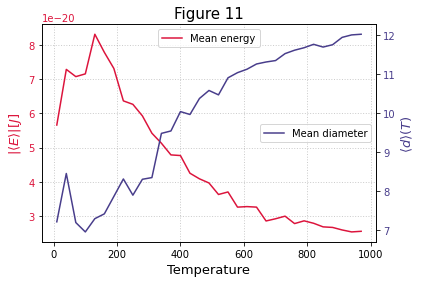

In [159]:
# Create figure and axes
fig, ax1 = plt.subplots()

# Plot on the first axes
ax1.plot(Temperature, np.abs(meansEArray), '-', label='Mean energy', color="crimson")
ax1.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
ax1.set_xlabel('Temperature', fontsize=13)
ax1.set_ylabel('$|\\langle E \\rangle| [J]$', color='crimson', fontsize=13)
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.legend(loc='upper center')
ax1.set_title('Figure 11', fontsize=15)

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
ax2.set_ylabel('$\\langle d \\rangle (T)$', color='darkslateblue', fontsize=13)
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.legend(loc='center right')

plt.show()

In this visualization, we have depicted the magnitude of the mean energy and the mean diameter on a shared plot, employing distinct scales on the y-axes to effectively present both variables. This approach facilitates a comprehensive comparison of the trends exhibited by the mean energy and mean diameter, despite their potentially disparate numerical ranges.  It is observed that the energy tends to increase as the diameter decreases. This correlation aligns with the understanding that more interactions between the monomers lead to a smaller mean diameter and a larger mean energy.

In [162]:
def metropolisWithDReverseT(V, N_s, T, polymer):
    """Inputs a polymer, number of attempted rotations, an interaction-energy matrix and temperature,
    and returns an array containing the average maximum distance between two monomers"""

    Temperature = np.arange(T, 10, -30)
    dArr = np.zeros(len(Temperature))
    
    for i in range(len(Temperature)):
        polymer, E, d = metropolisWithD(polymer, N_s, V, Temperature[i])
        dArr[i] = np.mean(d)
    return dArr, Temperature

dArr, T = metropolisWithDReverseT(V, N_s, 1000, polymer)

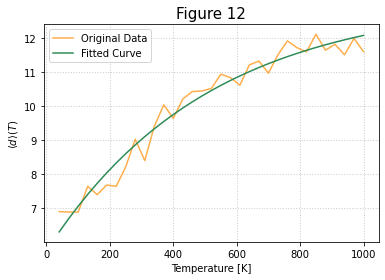

In [163]:
def func2(x,a,b,c):
    return 1-a*np.exp(-b*x)+c
#scatter eller lineplot? Spør på veiledning
initialGuess = (1, 0.01, 1)

popt3, pcov3 = curve_fit(func2, T, dArr, p0=initialGuess)
aFit, bFit, cFit = popt3
predictedY = func2(T, aFit,bFit,cFit)

plt.plot(T, dArr, alpha=0.7, color="darkorange", label="Original Data")
plt.plot(T, predictedY, '-', color="seagreen", label="Fitted Curve")
plt.grid(color='black', linestyle=':', linewidth=1, alpha=0.2)
plt.xlabel('Temperature [K]')
plt.ylabel('$\\langle d \\rangle (T)$')
plt.title("Figure 12", fontsize=15)
plt.legend()
plt.show()

### 2h)
